# XGBoost
* XGBoost (Extreme Gradient Boosting) is an optimized and efficient gradient boosting framework. It follows the usual Gradient Boosting process, but includes several key concepts to improve model performance, speed, and scalability.
    * Regularization: XGBoost includes L1 and L2 regularization terms to the algorithm's objective function to prevent overfitting and control tree complexity
    * Loss Functions: XGBoost gives users the option to define loss functions based on the specific problem, allowing flexibility for custom tasks
    * Tree Construction: XGBoost uses a histogram-based approach to find the best splits for the dataset. This involves precomputing statistics on features and storing them in histograms to speed up the process. XGBoost also handles sparse data by using a compressed format to skip missing/empty values
    * Missing Values: XGBoost handles missing values during the training step and can learn how to handle them based on the given data
    * Scalability: Parallel and distributed computing is supported, making it efficient for larger datasets
    * Categorical Features: Categorical features are encoded as integers and splits are done on these encodings (no need to do One-Hot Encoding)

XGBoost is currently regarded as one of the most powerful and effective machine learning algorithms. There are other packages that use the Gradient Boosting framework and are worth checking out (e.g. LightGBM, CatBoost). LightGBM focuses on optimizing memory usage and CatBoost (Categorical Boosting) handles categorical features more effectively by using a permutation-based approach to reduce overfitting from categorical features.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, cohen_kappa_score
from kappa_score import qwkappa

In [2]:
# read in test and train data from S3
import pandas as pd
test_data = pd.read_csv('https://project4-wine-quality-2023.s3.us-west-2.amazonaws.com/test.csv')
train_data = pd.read_csv('https://project4-wine-quality-2023.s3.us-west-2.amazonaws.com/train.csv')
submission = pd.read_csv('https://project4-wine-quality-2023.s3.us-west-2.amazonaws.com/test_submission.csv')

In [3]:
# Split the data into training and testing sets (Dont need to split the data due to using a pre-determined set of data)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = train_data.drop(['Id', 'quality'], axis= 1)
y_train = train_data['quality'].copy()
X_test = test_data.copy()
y_train-=3
qual_rating = y_train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=qual_rating ,test_size=0.2, random_state=42)


In [4]:
# create a sample weight class due to out of balance dataset
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(class_weight = 'balanced', y = y_train)

In [5]:
# Create an XGBoost classifier
xgb = XGBClassifier(objective = 'multi:softprob', num_class = 6, eval_metric = 'mlogloss')

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [20,25,30,40,50],
    'learning_rate': [0.01,0.05, 0.1,.15, 0.2],
    'max_depth': [3,4,5,6,7],
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(xgb, param_grid, cv=5, verbose = 3)
grid_search.fit(X_train, y_train)

# Get the best XGBoost model from grid search
best_xgb = grid_search.best_estimator_

# Make predictions on the test data using the best model
y_pred = best_xgb.predict(X_val)

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average="weighted")
precision = precision_score(y_val, y_pred, average="weighted")
recall = recall_score(y_val, y_pred, average="weighted")

Fitting 5 folds for each of 125 candidates, totalling 625 fits
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=20;, score=0.535 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=20;, score=0.596 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=20;, score=0.605 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=20;, score=0.556 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=20;, score=0.576 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=25;, score=0.541 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=25;, score=0.593 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=25;, score=0.587 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=25;, score=0.562 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=25;, score=0.573 total 

c:\Users\nicho\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 30}

In [7]:
kappa = qwkappa(y_val,y_pred)
kapp = cohen_kappa_score(y_val, y_pred, weights="quadratic")
print(f"kappa score: {kappa}")
print(f"kappa score: {kapp}")

kappa score: 0.5329696466706477
kappa score: 0.5329696466706477


In [8]:
# This set of code is for writing the confusion matrix to a text document
# from sklearn.metrics import confusion_matrix, classification_report
# f = open("xgboost_matrix.txt", "a")

# confusion_matrix(y_val, y_pred)
# f.write(str(classification_report(y_val,y_pred)))
# f.close()

In [9]:
final_model = XGBClassifier(objective = 'multi:softprob', num_class = 6, eval_metric = 'mlogloss', **grid_search.best_params_)

In [10]:
final_model.fit(train_data.drop(['Id', 'quality'], axis= 1), train_data['quality'] - 3)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=30, n_jobs=None,
              num_class=6, num_parallel_tree=None, objective='multi:softprob', ...)

In [11]:
y_pred = final_model.predict(X_test.drop('Id', axis = 1)) + 3

In [12]:
submission["quality"] = y_pred

In [13]:
submission.to_csv("test_submission.csv", index = False)

In [14]:

print(f"Best Estimators: {best_xgb.n_estimators}")
print(f"Best Learning Rate: {best_xgb.learning_rate}")
print(f"Best Max Depth: {best_xgb.max_depth}")
print(f"Accuracy: {accuracy:.2f}")
print(f"F1: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Best Estimators: 30
Best Learning Rate: 0.1
Best Max Depth: 3
Accuracy: 0.61
F1: 0.59
Precision: 0.58
Recall: 0.61


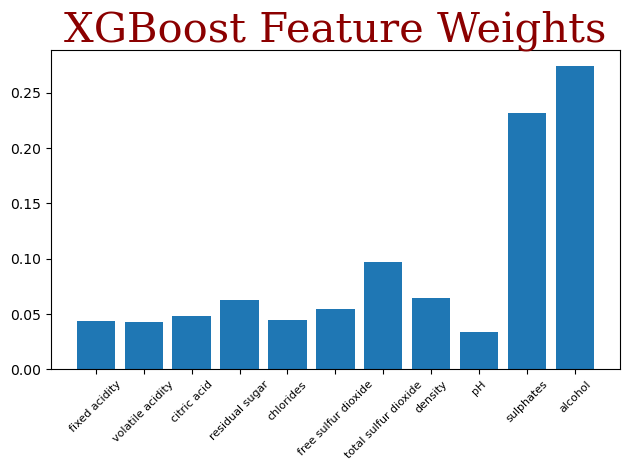

In [50]:
from matplotlib import pyplot as plt

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 30,
        }

plt.bar(final_model.feature_names_in_, final_model.feature_importances_)
plt.xticks(rotation=45,fontsize=8)
plt.title("XGBoost Feature Weights",fontdict=font)
plt.tight_layout()
plt.savefig("xgboost_features.png")
plt.show()